In [80]:
import pandas as pd

# -*- coding: utf-8 -*-
"""
@name: Week 3 Poisson GLM.py
@author: Ming-Long Lam, Ph.D.
@organization: University of Chicago
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sys
# Set some options for printing all the columns
np.set_printoptions(precision = 10, threshold = sys.maxsize)
np.set_printoptions(linewidth = np.inf)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', None)
pandas.options.display.float_format = '{:,.10}'.format
import seaborn as sns
import math
from scipy.stats import chi2

sys.path.append('C:\\MScAnalytics\\Linear and Nonlinear Model\\Job')
import Regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [81]:
target = 'Churn'
int_pred = ["MonthlyCharges","Tenure","TotalCharges"]
claim_history = pandas.read_excel('Telco-Customer-Churn.xlsx')
cat_cols = ["Dependents","Gender","MultipleLines","InternetService","PaperlessBilling","Partner","PhoneService","SeniorCitizen", "Contract"]
# Only positive
claim_history.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0002-ORFBO,Female,No,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3,No
1,0003-MKNFE,Male,No,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4,No
2,0004-TLHLJ,Male,No,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,Yes
3,0011-IGKFF,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,"1,237.85",Yes
4,0013-EXCHZ,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4,Yes


In [82]:
train_data = claim_history.copy()
train_data = train_data.dropna()
train_data[target] = np.where(train_data[target] == "Yes",1,0)

In [83]:
yFreq = train_data.groupby(target).size()
overall_odds = yFreq[1] / yFreq[0]
overall_odds

0.36199883788495063

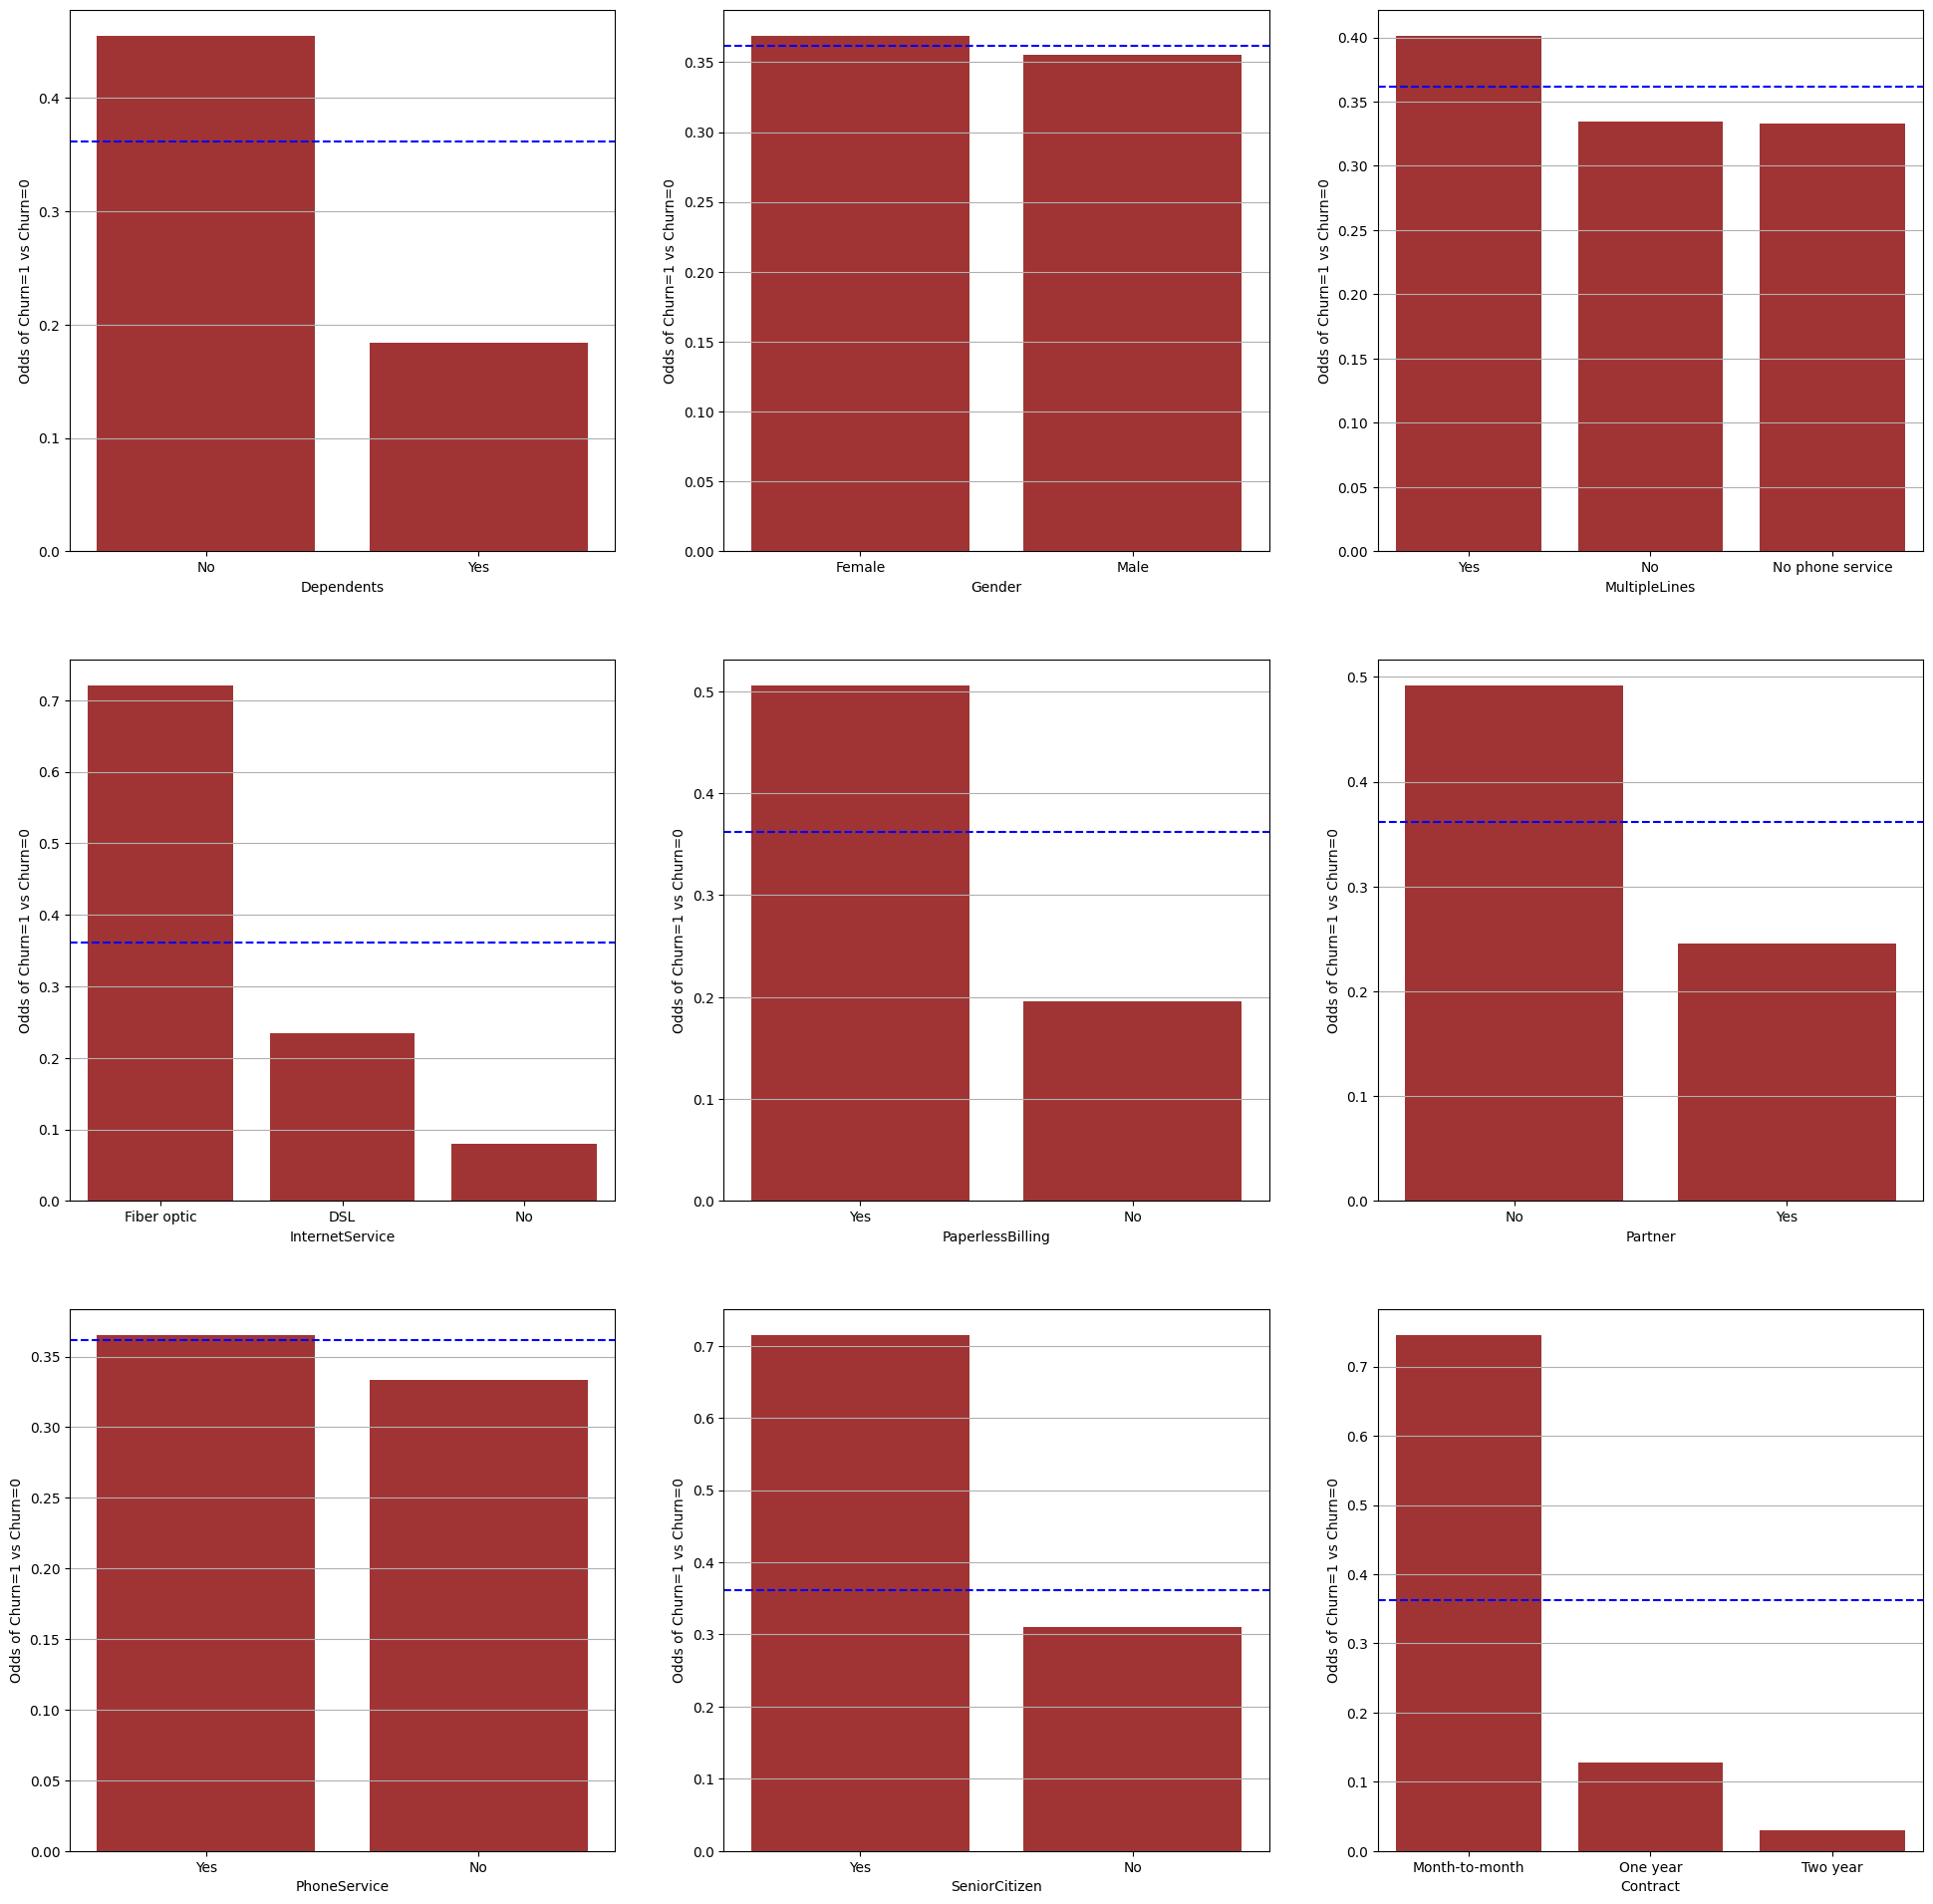

In [84]:

fig,axs = plt.subplots(math.ceil(len(cat_cols)/3),3, figsize = (24,24))
counter = 0
row_counter = 0
for i in cat_cols:
    xtab = pandas.crosstab(index = train_data[i], columns = train_data[target])
    xtab.reset_index(inplace = True)
    xtab['N'] = xtab[0] + xtab[1]
    xtab['Odds'] = xtab[1] / xtab[0]
    xtab.sort_values(by = 'Odds', inplace = True,ascending=False)
    plot = sns.barplot(xtab,x=i,y="Odds", color = 'firebrick',ax=axs[row_counter][counter])
    plot.axhline(y = overall_odds, color = 'blue', linestyle = '--', label = 'Overall Odds')
    plot.set_xlabel(i)
    plot.set_ylabel('Odds of Churn=1 vs Churn=0')
    plot.grid(axis ='y')
    if counter == 2:
        counter = 0
        row_counter+=1
    else:
        counter+=1

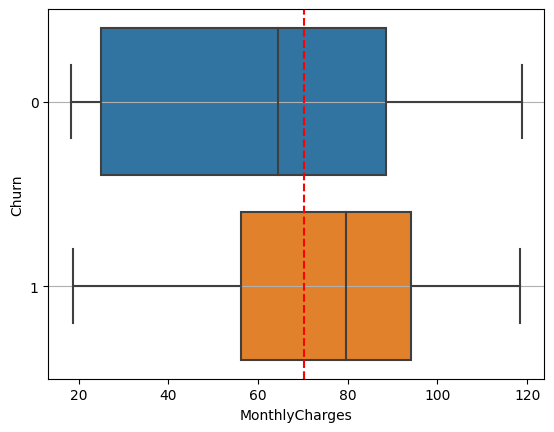

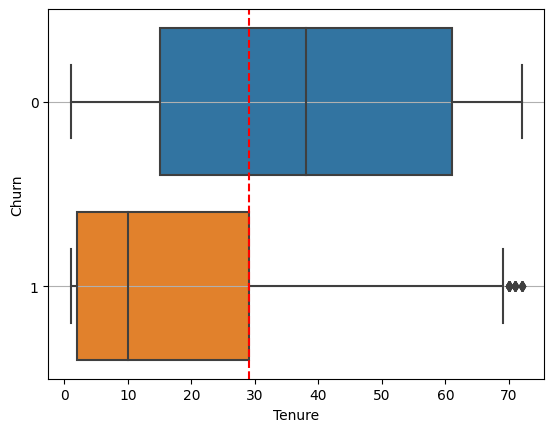

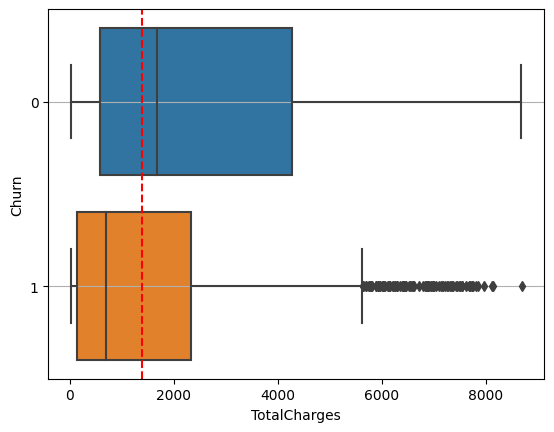

In [85]:
counter=0
for i in int_pred:
    predMedian = np.median(train_data[i])
    img = sns.boxplot(data=train_data,x = i, y = target, orient="h")
    img.axvline(x = predMedian, color = 'red', linestyle = '--')
    img.set_xlabel(i)
    img.set_ylabel("Churn")
    img.yaxis.grid(True)
    plt.show()

In [86]:
def create_categorical_value(dfs, column_name):
    u = dfs[column_name].astype('category')
    u_freq = u.value_counts(ascending=True)
    pm = u.cat.reorder_categories(list(u_freq.index))
    term_df_type = pandas.get_dummies(pm)
    term_df_type = term_df_type.add_suffix("_"+column_name)
    return term_df_type

In [87]:
def run_against_all(dfs, init_cols, categorical_cols, previous_train, output_train, ll, dv):
    step_detail = []
    output_list = []
    for i in init_cols:
        if i in categorical_cols:
            new_train = previous_train.drop(create_categorical_value(dfs, i).columns,axis=1)
        else:
            new_train = previous_train.drop(i,axis=1)
        regression_output = Regression.BinaryLogisticRegression(new_train, output_train)
        ll_1 = regression_output[3]
        dv_1 = len(regression_output[4])
        dev_chisq = 2 * (ll - ll_1)
        deviance_df = dv - dv_1
        dev_sig = chi2.sf(dev_chisq, deviance_df)
        if math.isnan(dev_sig):
            dev_sig = 1
        step_detail.append([str(i), dv_1, ll_1, dev_chisq, deviance_df, dev_sig])
        output_list.append(regression_output)
    step_df = pd.DataFrame(step_detail)
    chosen_value = step_df[step_df[5] == step_df[5].max()]
    chosen_output = output_list[step_df.index[step_df[5] == step_df[5].max()].tolist()[0]]
    return chosen_value.values, chosen_output

In [88]:
def backward_selector(data, target_col, init_cols, cat_columns):
    # First Run
    target_train = data[target_col]
    intercept_train = data[[target_col]]
    init = init_cols
    intercept_train.insert(0, 'Intercept', 1.0)
    intercept_train = intercept_train.drop(columns=target_col)
    intercept_train = intercept_train.join(train_data[init_cols])
    for i in cat_columns:
        intercept_train = intercept_train.join(create_categorical_value(data,i))
    init = init_cols + cat_columns
    intercept_result = Regression.BinaryLogisticRegression(intercept_train, target_train)
    step_summary = []
    ll = intercept_result[3]
    dv = len(intercept_result[4])
    dev_sig = 1
    threshold = 0.01
    value_outputs = None
    step_summary.append(['Intercept', dv, ll, np.nan, np.nan, np.nan])
    while dev_sig > threshold:
        run, s = run_against_all(data, init, cat_columns, intercept_train, target_train, ll, dv)
        run = run[0]
        ll = run[2]
        dv = run[1]
        dev_sig = run[5]
        if dev_sig > threshold:
            value_outputs = s
            if run[0] in cat_columns:
                intercept_train = intercept_train.drop(create_categorical_value(data, run[0]).columns,axis=1)
            else:
                intercept_train = intercept_train.drop(run[0],axis=1)
            init.remove(run[0])
            step_summary.append([run[0], dv, ll, run[3], run[4], run[5]])
    step_summary = pd.DataFrame(step_summary)
    
    return step_summary,value_outputs, intercept_result


In [89]:
df,out,init_res = backward_selector(train_data, target, int_pred, cat_cols)

In [90]:
df

,0,1,2,3,4,5
0,Intercept,15,"-2,967.432712",NaN,NaN,NaN
1,PhoneService,15,"-2,967.432712",0.0,0.0,1.0
2,Gender,14,"-2,967.452521",0.03961924055,1.0,0.8422268983
3,Partner,13,"-2,967.474361",0.04367849873,1.0,0.83445291
4,MonthlyCharges,12,"-2,967.598075",0.2474294451,1.0,0.6188909284
5,Dependents,11,"-2,969.968198",4.74024614,1.0,0.02946485533


In [91]:
parameter_table = out[0]
parameter_table

,Estimate,Standard Error,Lower 95% CI,Upper 95% CI
Intercept,0.7551658326,0.07348808423,0.6111318342,0.8991998309
Tenure,-0.06302183509,0.00587722624,-0.07454098685,-0.05150268333
TotalCharges,0.0003132504754,6.299039061e-05,0.0001897915785,0.0004367093724
No phone service_MultipleLines,0.7494693833,0.1288380151,0.4969515138,1.001987253
Yes_MultipleLines,0.293111832,0.07841998802,0.1394114798,0.4468121842
No_MultipleLines,0.0,0.0,0.0,0.0
No_InternetService,-1.637992723,0.1318300876,-1.896374947,-1.3796105
DSL_InternetService,-1.006367271,0.09315634561,-1.188950354,-0.823784189
Fiber optic_InternetService,0.0,0.0,0.0,0.0
No_PaperlessBilling,-0.4122853462,0.07290889824,-0.5551841609,-0.2693865315


In [92]:
profile = [1,29,1400,1,0,0,0,0,1,0,1,1,0,0,0,1]
estimates = parameter_table["Estimate"].values
pred_logit = sum([x*y for x,y in zip(estimates,profile)])
pred_odds = np.exp(pred_logit)/(1+np.exp(pred_logit))
pred_odds


0.6073319944090094

In [93]:
llk_initial = init_res[3]
llk_latest = out[3]
y = train_data[target].values
n = len(y)
rsq_mcf = 1 - (llk_latest/llk_initial)
rsq_cox = (2.0 / n) * (llk_initial - llk_latest)
rsq_cox = 1.0 - np.exp(rsq_cox)
upbound = (2.0 / n) * llk_initial
upbound = 1.0 - np.exp(upbound)
rsq_nag = rsq_cox / upbound
predprob_event = out[6][1]
# print(y)
s1 = np.mean(predprob_event[y == 1])
s0 = np.mean(predprob_event[y == 0])
rsq_tju = s1 - s0
outputs = pd.DataFrame({"McFadden" : [rsq_mcf],"Cox-Snell" : [rsq_cox],"Nagelkerke" : [rsq_nag],"Tjur" : [rsq_tju]})
outputs

,McFadden,Cox-Snell,Nagelkerke,Tjur
0,-0.0008544377947,-0.0007213882501,-0.001265584204,0.2907638199


In [94]:

value = Regression.binary_model_metric(target = y,valueEvent = 1,valueNonEvent = 0, predProbEvent = predprob_event)
auc = value [3]
print(" Area Under Curve = " + str(auc))


 Area Under Curve = 0.8411964188949088


In [95]:
rase = value[1]
print("Root Average Squared Error = "+str(rase))

Root Average Squared Error = 0.3708047029352164


In [96]:
curves = Regression.curve_coordinates(y,1,0,predprob_event)
curves

,Threshold,Sensitivity,OneMinusSpecificity,Precision,Recall,F1 Score
0,0.0008726487296,1.0,1.0,0.2657849829,1.0,0.4199528143
1,0.0008775924679,1.0,0.9998063142,0.2658227848,1.0,0.42
2,0.0008863010359,1.0,0.9996126283,0.2658605974,1.0,0.4200471963
3,0.000888759321,1.0,0.9994189425,0.2658984208,1.0,0.4200944032
4,0.000893374749,1.0,0.9992252566,0.265936255,1.0,0.4201416208
...,...,...,...,...,...,...
6882,0.7915336504,0.002675227394,0.0,1.0,0.002675227394,0.005336179296
6883,0.7916860915,0.002140181915,0.0,1.0,0.002140181915,0.004271222637
6884,0.791709338,0.001605136437,0.0,1.0,0.001605136437,0.003205128205
6885,0.7917661548,0.001070090958,0.0,1.0,0.001070090958,0.002137894174


In [97]:
sen_spec = curves[["Threshold","Sensitivity","OneMinusSpecificity"]].copy()
melted = pd.melt(sen_spec,["Threshold"])
melted

,Threshold,variable,value
0,0.0008726487296,Sensitivity,1.0
1,0.0008775924679,Sensitivity,1.0
2,0.0008863010359,Sensitivity,1.0
3,0.000888759321,Sensitivity,1.0
4,0.000893374749,Sensitivity,1.0
...,...,...,...
13769,0.7915336504,OneMinusSpecificity,0.0
13770,0.7916860915,OneMinusSpecificity,0.0
13771,0.791709338,OneMinusSpecificity,0.0
13772,0.7917661548,OneMinusSpecificity,0.0


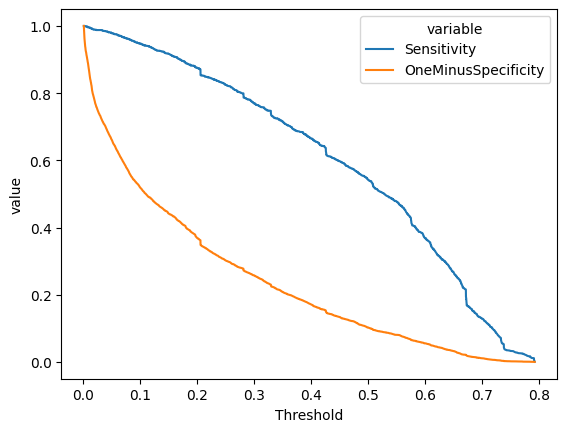

In [98]:
lines = sns.lineplot(x="Threshold",y="value",hue="variable",data = melted)
plt.show()

In [99]:
sen_spec["variation"] = sen_spec["Sensitivity"] - sen_spec["OneMinusSpecificity"]
kms_statistic = sen_spec["variation"].max()
kms_threshold = sen_spec[sen_spec["variation"] == sen_spec["variation"].max()]
kms_threshold = kms_threshold.iloc[0,0]
print(kms_statistic,kms_threshold)

0.5244664390313967 0.2579355595500369


In [106]:
aggrProb = pandas.crosstab(predprob_event, y, dropna = True)
threshValue = aggrProb.index
nTN = np.sum(aggrProb[0].iloc[threshValue < kms_threshold])
misscalc_rate_kms = nTN/len(y)
misscalc_rate_kms

0.5170648464163823

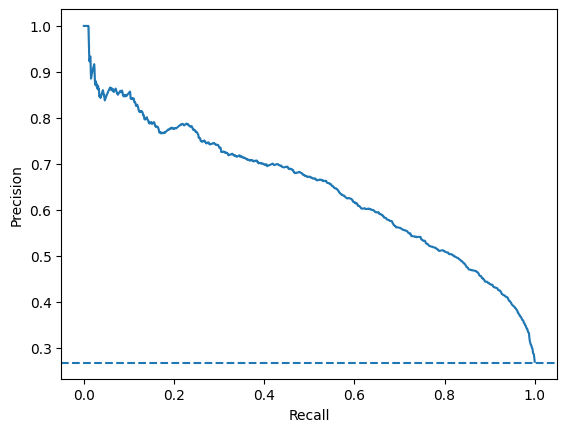

In [101]:
lines_pre = sns.lineplot(data = curves,x="Recall",y="Precision",)
no_skill_value = (len(y[y==1])/len(y))
plt.axhline(no_skill_value,0,1,linestyle="--")
plt.show()


In [107]:
f1 = curves["F1 Score"].max()
f1_threshold = curves[curves["F1 Score"] == f1].iloc[0,0]
nTN_f1 = np.sum(aggrProb[0].iloc[threshValue < f1_threshold])
misscalc_rate_f1 = nTN_f1/len(y)
misscalc_rate_f1

0.5656996587030717